In [208]:
%matplotlib inline
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
torch.set_printoptions(edgeitems=2, linewidth=75)

In [209]:
# CSVファイルの読み込み
df1 = pd.read_csv('xy(1).csv')
df2 = pd.read_csv('xy(2).csv')
df3 = pd.read_csv('xy(3).csv')

# データの抽出
x1 = df1['x'].values
y1 = df1['y'].values
x2 = df2['x'].values
y2 = df2['y'].values
x3 = df3['x'].values
y3 = df3['y'].values

x1 = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
y1 = torch.tensor(y1, dtype=torch.float32)
x2 = torch.tensor(x2, dtype=torch.float32, requires_grad=True)
y2 = torch.tensor(y2, dtype=torch.float32)
x3 = torch.tensor(x3, dtype=torch.float32, requires_grad=True)
y3 = torch.tensor(y3, dtype=torch.float32)

In [210]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * K * K
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad
    
    E = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor(2.0 * torch.pi / 3.0)) # for Te3.
    C3i = C3.T # for Te2.
    Rs = torch.stack([E, C3i, C3])
    
    # nt = cross_product(torch.stack[nx,ny,nz], torch.stack[sx,sy,sz])
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    # ht = magnetic(torch.stack([nt]), torch.stack([sx,sy,sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])    
    # 63個のスカラー結果を得るための計算
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R.T) for R in Rs]
    shift = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    return shift

# # パラメータの定義
# k1 = torch.tensor(-8.572, requires_grad=True)
# k2 = torch.tensor(1.146, requires_grad=True)
# k3 = torch.tensor(0.0, requires_grad=True)
# k4 = torch.tensor(8.830, requires_grad=True)
# k5 = torch.tensor(0.0, requires_grad=True)
# k6 = torch.tensor(0.0, requires_grad=True)
# t1 = torch.tensor(0.0, requires_grad=True)
# p1 = torch.tensor(0.0, requires_grad=True)
# t2 = torch.tensor(90.0, requires_grad=True)
# p2 = torch.tensor(0.0, requires_grad=True)

# # 各xに対する勾配計算の準備
# k1_grads = []
# k2_grads = []
# k3_grads = []
# k4_grads = []
# k5_grads = []
# k6_grads = []
# t1_grads = []
# p1_grads = []
# t2_grads = []
# p2_grads = []

# for i in range(len(x1)):
#     # 1つのx値に対してモデルを計算
#     y_p1 = model(x1[i:i+1], k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[0]
    
#     # 勾配計算のためのテンソル
#     v = torch.ones_like(y_p1)
    
#     # 勾配計算
#     y_p1.backward(v, retain_graph=True)
    
#     # 各パラメータの勾配を保存
#     k1_grads.append(k1.grad.item())
#     k2_grads.append(k2.grad.item())
#     k3_grads.append(k3.grad.item())
#     k4_grads.append(k4.grad.item())
#     k5_grads.append(k5.grad.item())
#     k6_grads.append(k6.grad.item())
#     t1_grads.append(t1.grad.item())
#     p1_grads.append(p1.grad.item())
#     t2_grads.append(t2.grad.item())
#     p2_grads.append(p2.grad.item())
    
#     # 勾配のリセット
#     k1.grad.zero_()
#     k2.grad.zero_()
#     k3.grad.zero_()
#     k4.grad.zero_()
#     k5.grad.zero_()
#     k6.grad.zero_()
#     t1.grad.zero_()
#     p1.grad.zero_()
#     t2.grad.zero_()
#     p2.grad.zero_()

# for i in range(len(x2)):
#     # 1つのx値に対してモデルを計算
#     y_p2 = model(x2[i:i+1], k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[1]
    
#     # 勾配計算のためのテンソル
#     v = torch.ones_like(y_p2)
    
#     # 勾配計算
#     y_p2.backward(v, retain_graph=True)
    
#     # 各パラメータの勾配を保存
#     k1_grads.append(k1.grad.item())
#     k2_grads.append(k2.grad.item())
#     k3_grads.append(k3.grad.item())
#     k4_grads.append(k4.grad.item())
#     k5_grads.append(k5.grad.item())
#     k6_grads.append(k6.grad.item())
#     t1_grads.append(t1.grad.item())
#     p1_grads.append(p1.grad.item())
#     t2_grads.append(t2.grad.item())
#     p2_grads.append(p2.grad.item())
    
#     # 勾配のリセット
#     k1.grad.zero_()
#     k2.grad.zero_()
#     k3.grad.zero_()
#     k4.grad.zero_()
#     k5.grad.zero_()
#     k6.grad.zero_()
#     t1.grad.zero_()
#     p1.grad.zero_()
#     t2.grad.zero_()
#     p2.grad.zero_()

# for i in range(len(x3)):
#     # 1つのx値に対してモデルを計算
#     y_p3 = model(x3[i:i+1], k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[2]
    
#     # 勾配計算のためのテンソル
#     v = torch.ones_like(y_p3)
    
#     # 勾配計算
#     y_p3.backward(v, retain_graph=True)
    
#     # 各パラメータの勾配を保存
#     k1_grads.append(k1.grad.item())
#     k2_grads.append(k2.grad.item())
#     k3_grads.append(k3.grad.item())
#     k4_grads.append(k4.grad.item())
#     k5_grads.append(k5.grad.item())
#     k6_grads.append(k6.grad.item())
#     t1_grads.append(t1.grad.item())
#     p1_grads.append(p1.grad.item())
#     t2_grads.append(t2.grad.item())
#     p2_grads.append(p2.grad.item())
    
#     # 勾配のリセット
#     k1.grad.zero_()
#     k2.grad.zero_()
#     k3.grad.zero_()
#     k4.grad.zero_()
#     k5.grad.zero_()
#     k6.grad.zero_()
#     t1.grad.zero_()
#     p1.grad.zero_()
#     t2.grad.zero_()
#     p2.grad.zero_()

# # リストをtorch.tensorに変換
# k1_grads = torch.tensor(k1_grads)
# k2_grads = torch.tensor(k2_grads)
# k3_grads = torch.tensor(k3_grads)
# k4_grads = torch.tensor(k4_grads)
# k5_grads = torch.tensor(k5_grads)
# k6_grads = torch.tensor(k6_grads)
# t1_grads = torch.tensor(t1_grads)
# p1_grads = torch.tensor(p1_grads)
# t2_grads = torch.tensor(t2_grads)
# p2_grads = torch.tensor(p2_grads)

In [211]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [212]:
def combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3):
    y_p1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[0]
    y_p2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[1]
    y_p3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[2]

    loss1 = loss_fn(y_p1, y1)
    loss2 = loss_fn(y_p2, y2)
    loss3 = loss_fn(y_p3, y3)

    total_loss = loss1 + loss2 + loss3
    return total_loss

In [213]:
# delta = 0.1

# learning_rate = 1e-2

# loss_rate_of_change_k1 = \
#     (loss_fn(model(x, k1 + delta, k2, k3, k4, k5, k6, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1 - delta, k2, k3, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

# k1 = k1 - learning_rate * loss_rate_of_change_k1

# loss_rate_of_change_k2 = \
#     (loss_fn(model(x, k1, k2 + delta, k3, k4, k5, k6, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2 - delta, k3, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

# k2 = k2 - learning_rate * loss_rate_of_change_k2

# loss_rate_of_change_k3 = \
#     (loss_fn(model(x, k1, k2, k3 + delta, k4, k5, k6, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3 - delta, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

# k3 = k3 - learning_rate * loss_rate_of_change_k3

# loss_rate_of_change_k4 = \
#     (loss_fn(model(x, k1, k2, k3, k4 + delta, k5, k6, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4 - delta, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

# k4 = k4 - learning_rate * loss_rate_of_change_k4

# loss_rate_of_change_k5 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5 + delta, k6, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5 - delta, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

# k5 = k5 - learning_rate * loss_rate_of_change_k5

# loss_rate_of_change_k6 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5, k6 + delta, t1, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5, k6 - delta, t1, p1, t2, p2), y)) / (2.0 * delta)

# k6 = k6 - learning_rate * loss_rate_of_change_k6

# loss_rate_of_change_t1 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1 + delta, p1, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1 - delta, p1, t2, p2), y)) / (2.0 * delta)

# t1 = t1 - learning_rate * loss_rate_of_change_t1

# loss_rate_of_change_p1 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1 + delta, t2, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1 - delta, t2, p2), y)) / (2.0 * delta)

# p1 = p1 - learning_rate * loss_rate_of_change_p1

# loss_rate_of_change_t2 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2 + delta, p2), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2 - delta, p2), y)) / (2.0 * delta)

# t2 = t2 - learning_rate * loss_rate_of_change_t2

# loss_rate_of_change_p2 = \
#     (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 + delta), y) - 
#      loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 - delta), y)) / (2.0 * delta)

# p2 = p2 - learning_rate * loss_rate_of_change_p2

In [214]:
# def dloss_fn(y_p, y):
#     dsq_diffs = 2 * (y_p - y) / y_p.size(0)  # <1>
#     return dsq_diffs

In [215]:
# def dmodel_dk1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k1_grads

# def dmodel_dk2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k2_grads

# def dmodel_dk3(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k3_grads

# def dmodel_dk4(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k4_grads

# def dmodel_dk5(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k5_grads

# def dmodel_dk6(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return k6_grads

# def dmodel_dt1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return t1_grads

# def dmodel_dp1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return p1_grads

# def dmodel_dt2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return t2_grads

# def dmodel_dp2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     return p2_grads

In [216]:
# def grad_fn(x, y, y_p, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
#     dloss_dyp = dloss_fn(y_p, y)
#     dloss_dk1 = dloss_dyp * dmodel_dk1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dk2 = dloss_dyp * dmodel_dk2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dk3 = dloss_dyp * dmodel_dk3(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dk4 = dloss_dyp * dmodel_dk4(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dk5 = dloss_dyp * dmodel_dk5(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dk6 = dloss_dyp * dmodel_dk6(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dt1 = dloss_dyp * dmodel_dt1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dp1 = dloss_dyp * dmodel_dp1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dt2 = dloss_dyp * dmodel_dt2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     dloss_dp2 = dloss_dyp * dmodel_dp2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     return torch.stack([dloss_dk1.sum(), dloss_dk2.sum(), dloss_dk3.sum(), dloss_dk4.sum(), dloss_dk5.sum(), dloss_dk6.sum(), dloss_dt1.sum(), dloss_dp1.sum(), dloss_dt2.sum(), dloss_dp2.sum()])  # <1>

In [217]:
# def combined_grad_fn(x1, y1, y_p1, x2, y2, y_p2, x3, y3, y_p3, params):
#     k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = params

#     y_p1 = model_K1(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     y_p2 = model_K2(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     y_p3 = model_K3(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)

#     grad1 = grad_fn(x1, y1, y_p1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     grad2 = grad_fn(x2, y2, y_p2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#     grad3 = grad_fn(x3, y3, y_p3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)

#     total_grad = grad1 + grad2 + grad3
#     return total_grad

In [218]:
import torch.optim as optim

# Define model parameters as torch.nn.Parameter
k1 = torch.nn.Parameter(torch.tensor(-8.572))
k2 = torch.nn.Parameter(torch.tensor(1.146))
k3 = torch.nn.Parameter(torch.tensor(0.0))
k4 = torch.nn.Parameter(torch.tensor(8.830))
k5 = torch.nn.Parameter(torch.tensor(0.0))
k6 = torch.nn.Parameter(torch.tensor(0.0))
t1 = torch.nn.Parameter(torch.tensor(0.0))
p1 = torch.nn.Parameter(torch.tensor(0.0))
t2 = torch.nn.Parameter(torch.tensor(90.0))
p2 = torch.nn.Parameter(torch.tensor(0.0))

# Use an optimizer
optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

# Training loop
for epoch in range(1000):  # Run for a sufficient number of epochs
    optimizer.zero_grad()  # Clear previous gradients
    
    # Forward pass
    y_p1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[0]
    y_p2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[1]
    y_p3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[2]
    
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 360.8315734863281
Epoch 100, Loss: 53.429161071777344
Epoch 200, Loss: 23.173179626464844
Epoch 300, Loss: 22.253398895263672
Epoch 400, Loss: 21.776765823364258
Epoch 500, Loss: 21.327205657958984
Epoch 600, Loss: 20.912946701049805
Epoch 700, Loss: 20.5362491607666
Epoch 800, Loss: 20.19606590270996
Epoch 900, Loss: 19.889795303344727


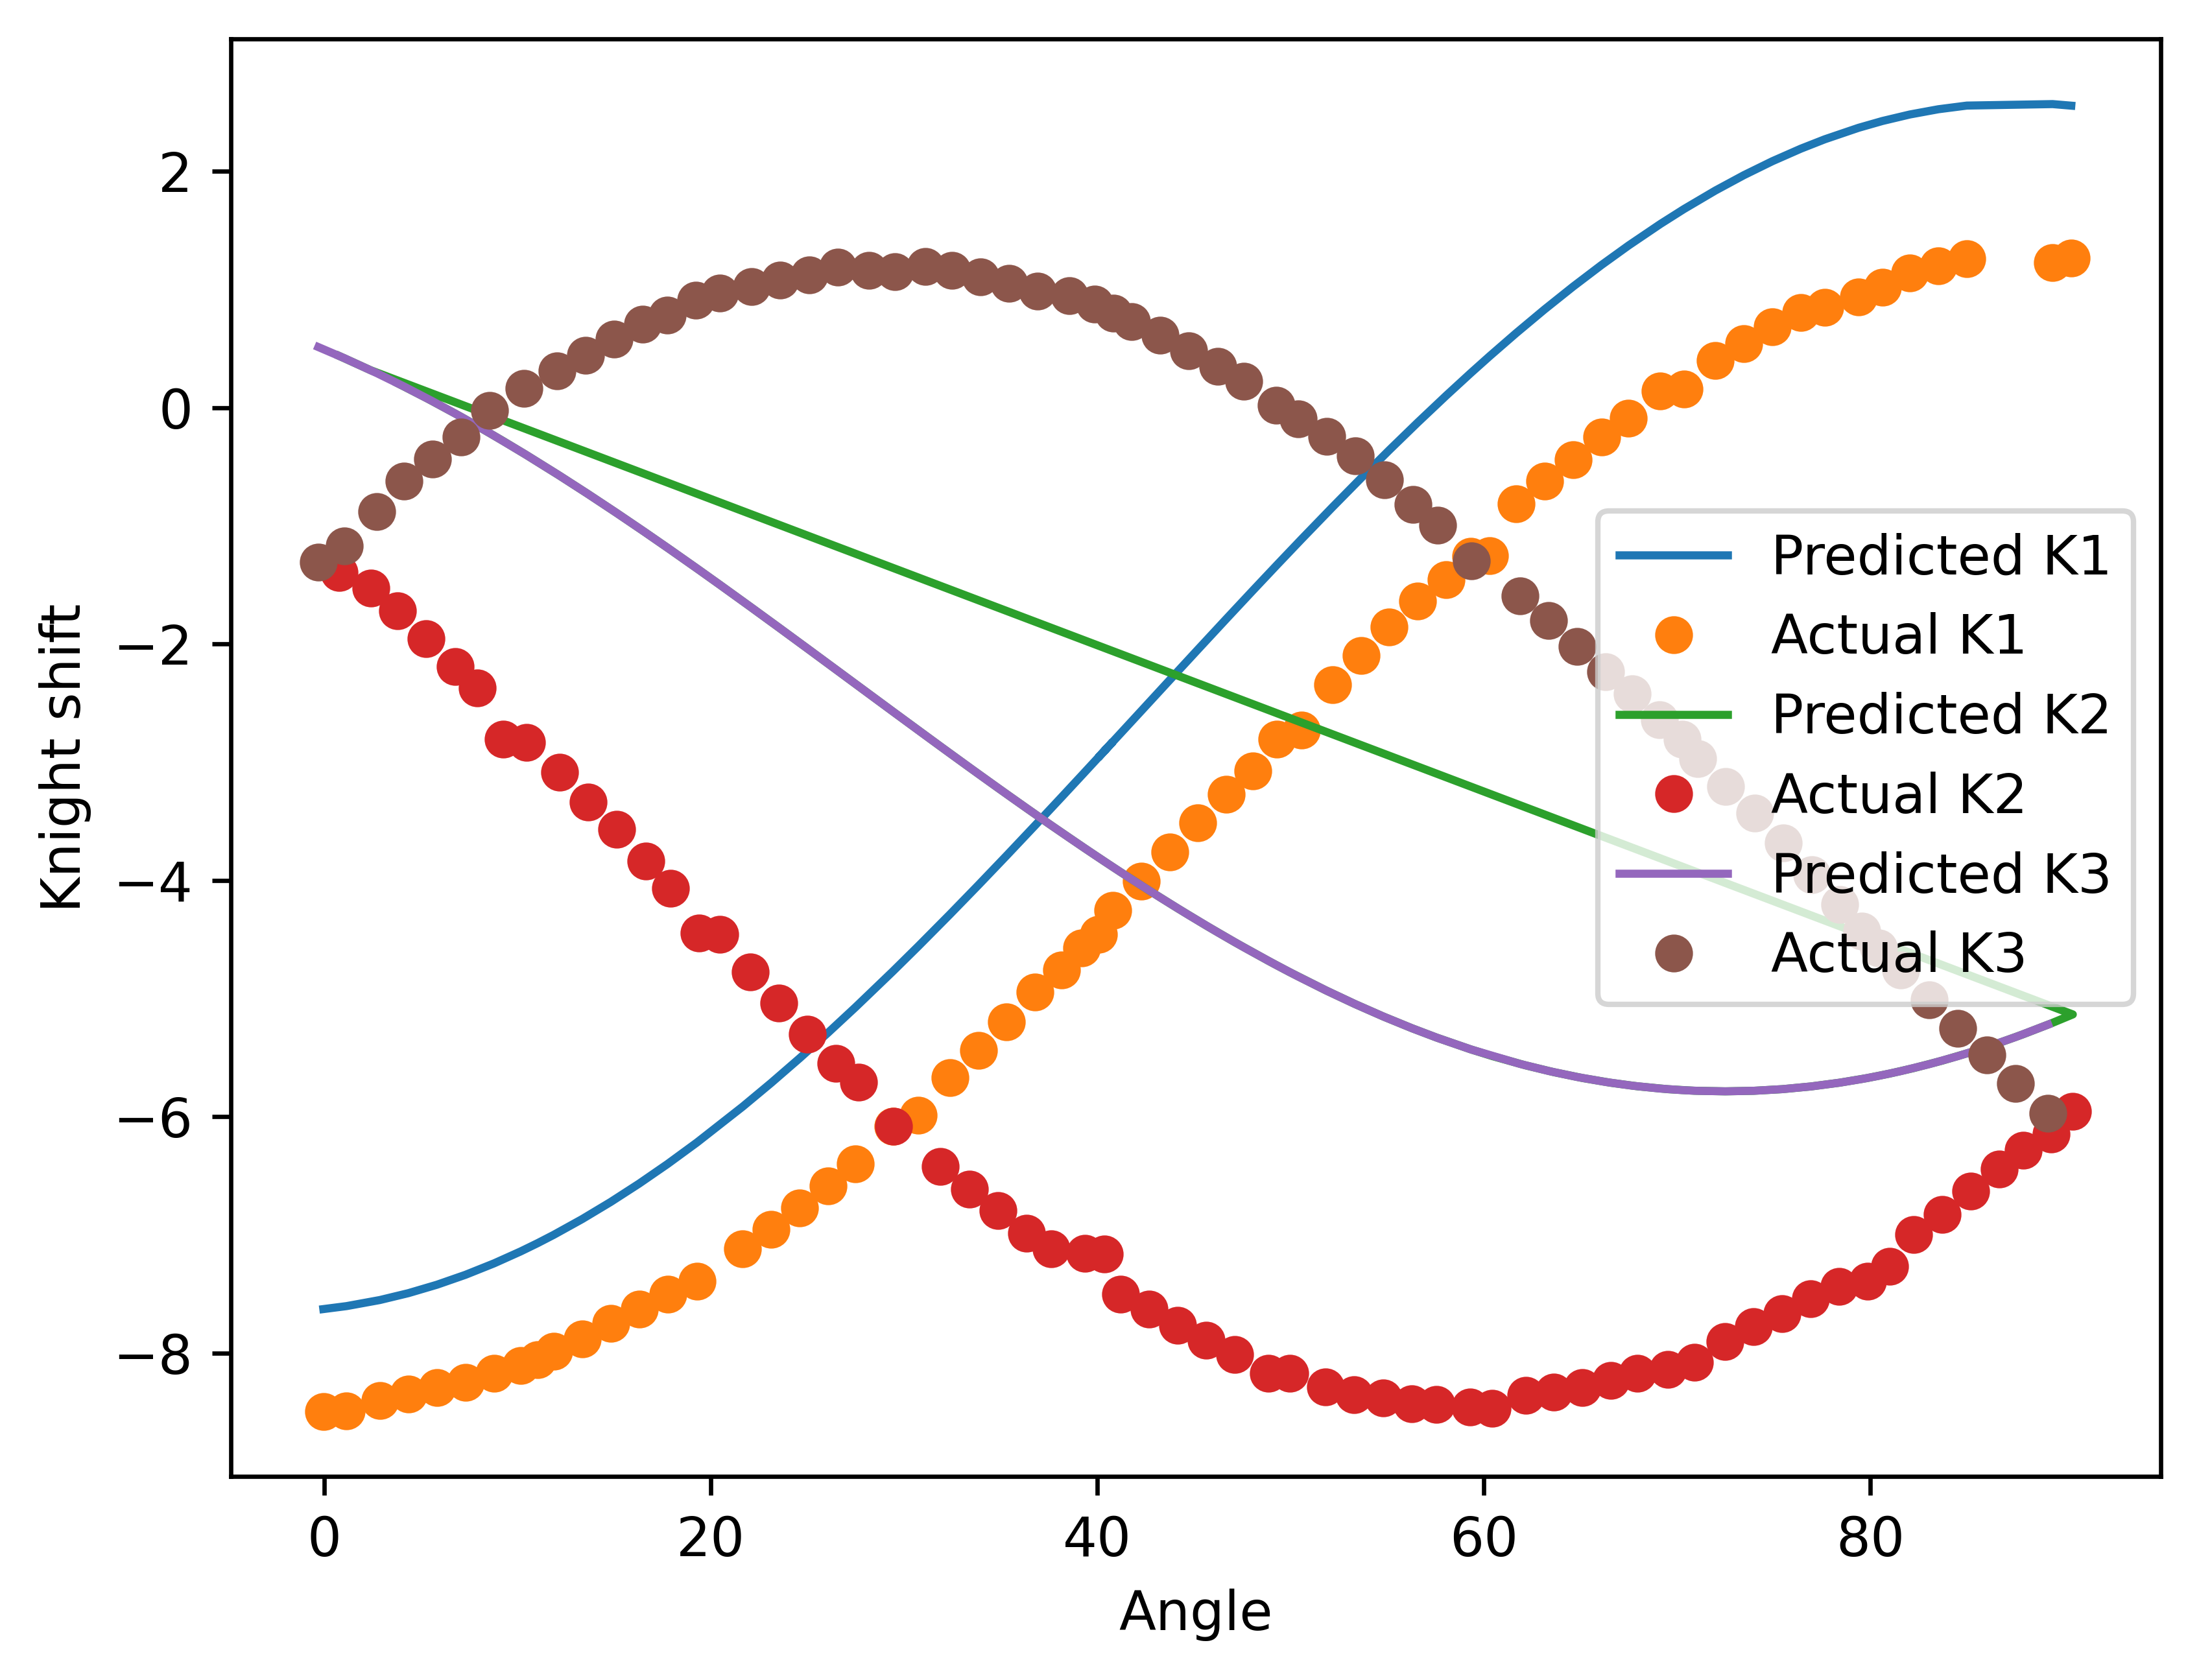

[tensor(-7.4652), tensor(2.2137), tensor(-2.3664), tensor(9.3206), tensor(0.7626), tensor(1.3341), tensor(0.1371), tensor(-1.2211), tensor(89.5571), tensor(-5.2273)]


In [219]:
# 最適化後のパラメータを取得し、Tensorに変換
params = [torch.tensor(val) for val in [k1.item(), k2.item(), k3.item(), k4.item(), k5.item(), k6.item(), t1.item(), p1.item(), t2.item(), p2.item()]]

# モデルの出力を計算
y_p1 = model(x1, *params)[0]
y_p2 = model(x2, *params)[1]
y_p3 = model(x3, *params)[2]

# 結果の可視化
fig = plt.figure(dpi=600)
plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()
print(params)

In [220]:
# def training_loop(n_epochs, learning_rate, params, x, y):
#     for epoch in range(1, n_epochs + 1):
#         k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = params

#         y_p1 = modelK1(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)  # <1>
#         y_p2 = modelK2(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#         y_p3 = modelK3(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
#         loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3)
#         grad = combined_grad_fn(x1, y1, y_p1, x2, y2, y_p2, x3, y3, y_p3, params)  # <2>
        
#         print(grad)
#         print(grad.shape)

#         params = params - learning_rate * grad

#         print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
#     return params

In [221]:
# def training_loop(n_epochs, learning_rate, params, x, y,
#                   print_params=True):
#     for epoch in range(1, n_epochs + 1):
#         k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = params

#         y_p1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[0]  # <1>
#         y_p2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[1]
#         y_p3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)[2]
#         loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3)
#         grad = combined_grad_fn(x1, y1, y_p1, x2, y2, y_p2, x3, y3, y_p3, params)  # <2>

#         params = params - learning_rate * grad

#         if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
#             print('Epoch %d, Loss %f' % (epoch, float(loss)))
#             if print_params:
#                 print('    Params:', params)
#                 print('    Grad:  ', grad)
#         if epoch in {4, 12, 101}:
#             print('...')

#         if not torch.isfinite(loss).all():
#             break  # <3>
            
#     return params

In [222]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([-8.572, 1.146, 0.0, 8.830, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0]), 
    x1=x1, y1=y1, x2=x2, y2=y2, x3=x3, y3=y3)

NameError: name 'training_loop' is not defined

In [ ]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([-8.572, 1.146, 0.0, 8.830, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0]),
    x1=x1, y1=y1, x2=x2, y2=y2, x3=x3, y3=y3,
    print_params = False)

params

Epoch 1, Loss 0.023659
Epoch 2, Loss 0.022834
Epoch 3, Loss 0.022041
...
Epoch 10, Loss 0.017321
Epoch 11, Loss 0.016751
...
Epoch 99, Loss 0.003378
Epoch 100, Loss 0.003361
...
Epoch 4000, Loss 0.001944
Epoch 5000, Loss 0.001944


tensor([-8.4307e+00,  1.2911e+00,  5.4793e-16,  8.8300e+00, -1.5164e-08,
        -1.0930e-02,  3.9535e-02,  0.0000e+00,  8.9962e+01, -1.8539e-03],
       grad_fn=<SubBackward0>)

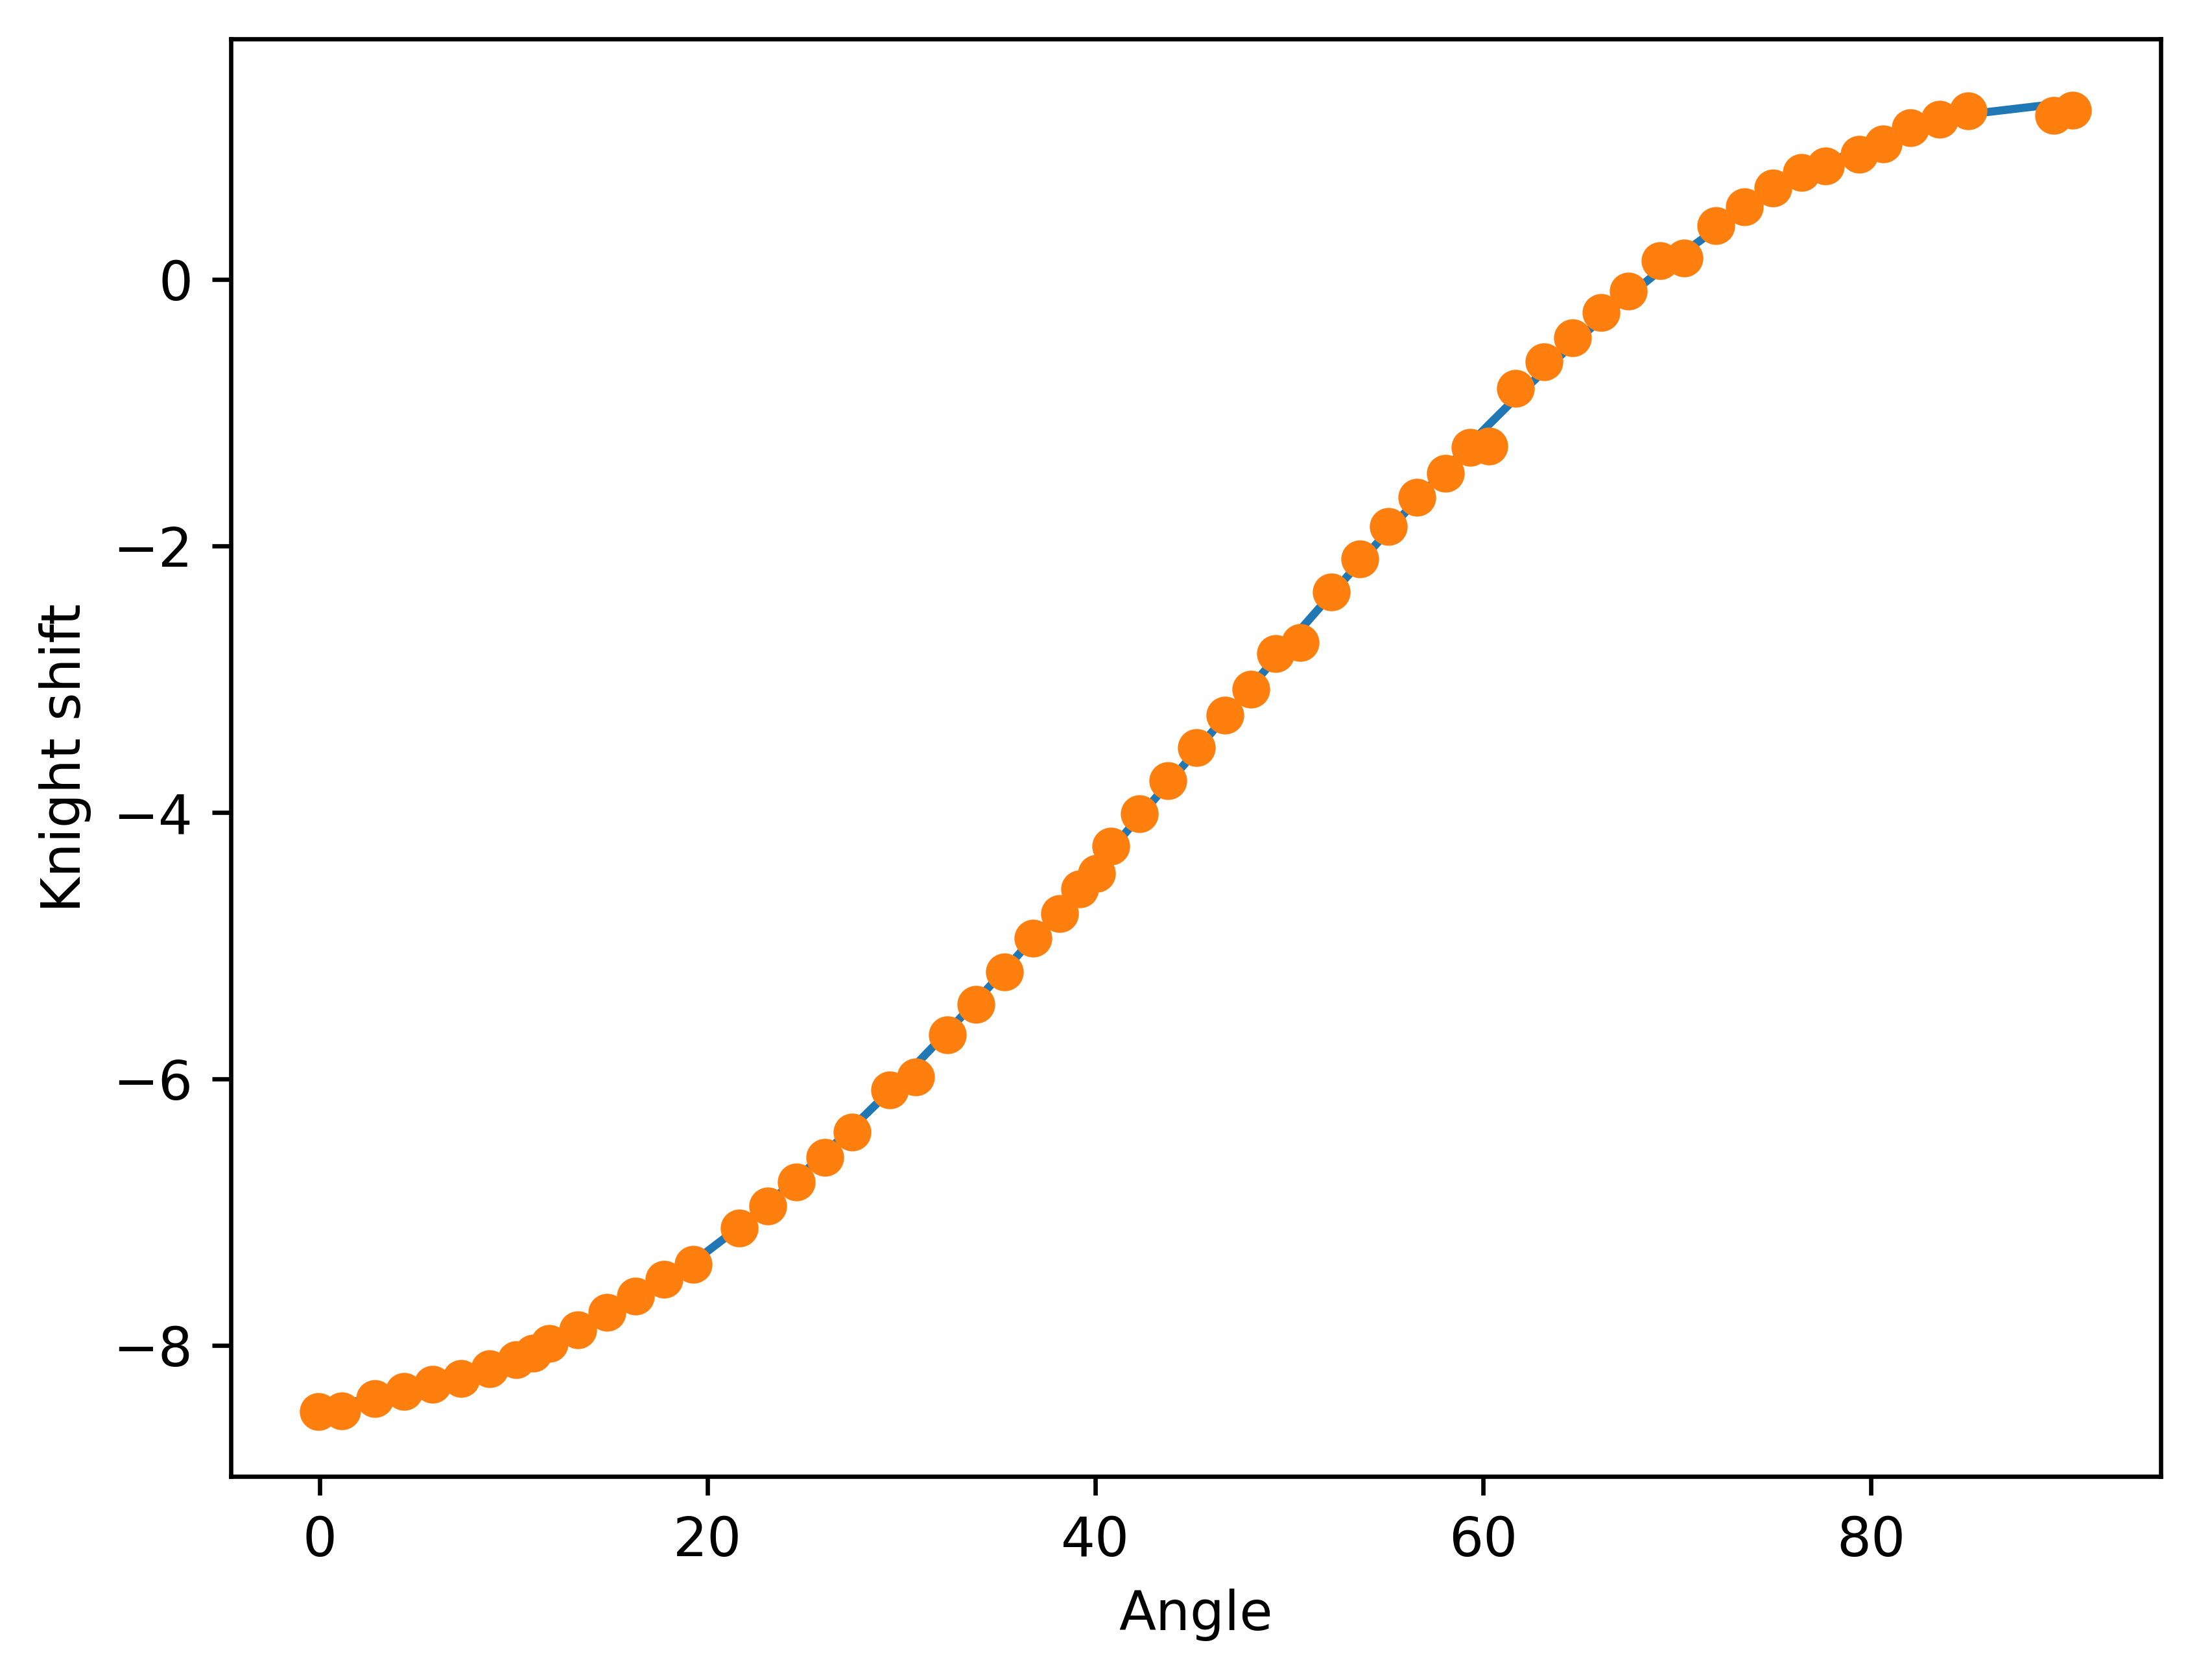

In [ ]:
# 結果の可視化
y_p1 = model_K1(x1, *params)
y_p2 = model_K2(x2, *params)
y_p3 = model_K3(x3, *params)

fig = plt.figure(dpi=600)
plt.plot(x1.detach().numpy(), y_p1.detach().numpy()) # <2>
plt.plot(x1.detach().numpy(), y1.numpy(), 'o')
plt.plot(x2.detach().numpy(), y_p2.detach().numpy()) # <2>
plt.plot(x2.detach().numpy(), y2.numpy(), 'o')
plt.plot(x3.detach().numpy(), y_p3.detach().numpy()) # <2>
plt.plot(x3.detach().numpy(), y3.numpy(), 'o')
plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.show()